<a href="https://colab.research.google.com/github/nsk31512/libr_for_ds/blob/project/VAKuznetsov_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Требования:

Оформить ноутбук с основными этапами:

подготовка данных
анализ
визуализация
обработка выбросов
обработка пропусков
генерация новых признаков
обучение модели
проверка качества модели
Предсказать цены для квартир из test.csv и выслать файл на проверку.

Что обязательно стоит попробовать:

Тщательный анализ данных
Поиск странных значений (ошибок, аномалий, выбросов)
Предобработка данных, но без фанатизма!
Проверка разных моделей
Подбор гиперпараметров лучшей модели
Отбор сильных признаков

#Введение

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


В данном разделе представлены все импортируемые модули, использованные при работе.

In [123]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [124]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 14})

In [125]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/train.csv', index_col='Id')

In [126]:
#df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/test.csv', index_col='Id')

#Обработка тренировочного датасета

In [127]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

В датасете присутсвуют пропуски в столбцах "LifeSquare" и "Healthcare_1", при этом количество пропущенных значений составляет более 20%, а значит просто удалить данные строки нельзя и требуется их обработать

In [129]:
df_train.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [130]:
10000-2113, 10000-5202

(7887, 4798)

Из двух вышеобозначенных строк кода можно сделать вывод, что пропущенные строки заполненны Null, а не каким-то объектом.

In [131]:
#Выделение из основного датасета таблцы с Null для столбца LifeSquare
df_LSq_null = df_train[df_train['LifeSquare'].isnull()]

Для нахождения зависимостей в следующх двух строках запрашиваем статистические показатели общей таблицы и таблицы с пропусками LifeSquare

In [132]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [133]:
df_LSq_null.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,2113.000000,2113.000000,2113.000000,0.0,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,745.000000,2113.000000,2113.000000,2113.000000
mean,26.999527,1.778987,60.352646,NaN,1.383814,9.913393,13.248935,1981.707525,0.105183,10.528159,2569.010885,10.899195,733.229530,0.565547,3.111690,179534.185327
std,24.928012,0.764316,22.846588,NaN,2.725244,5.563304,8.091366,12.690541,0.113981,12.871756,3021.569733,35.099679,513.620168,1.117011,5.872527,75178.459104
min,0.000000,0.000000,17.414181,NaN,0.000000,1.000000,0.000000,1977.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,60502.583500
25%,6.000000,1.000000,43.624731,NaN,1.000000,5.000000,4.000000,1977.000000,0.007122,2.000000,469.000000,0.000000,540.000000,0.000000,0.000000,130409.470602
50%,23.000000,2.000000,58.634866,NaN,1.000000,9.000000,17.000000,1977.000000,0.072158,5.000000,1437.000000,0.000000,540.000000,0.000000,1.000000,167088.412963
75%,33.000000,2.000000,68.843287,NaN,1.000000,14.000000,17.000000,1977.000000,0.197368,22.000000,5212.000000,3.000000,1046.000000,0.000000,2.000000,205482.588565
max,190.000000,5.000000,604.705972,NaN,62.000000,27.000000,30.000000,2019.000000,0.437885,53.000000,14892.000000,141.000000,4702.000000,6.000000,23.000000,633233.466570


Из двух таблиц выше видно, что максимальные значения в столбцах комнат и общей площади значительно больше 3 квартиля. Более того, существует квартира, в которой жилая площадь больше общей площади. Перед обработкой пропусков следует обработать данные значения.

 ## Удаление выбросов Rooms

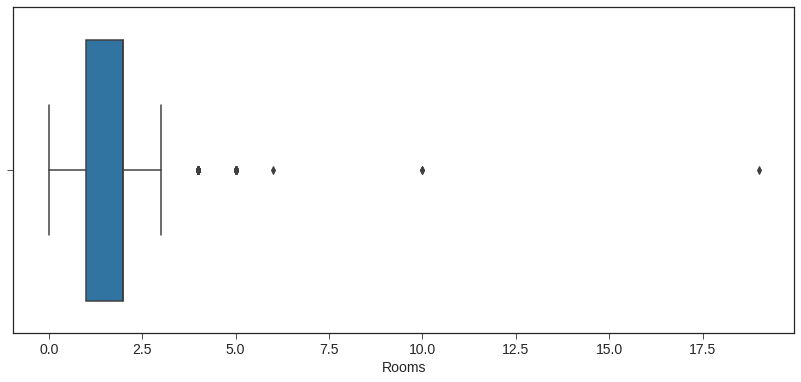

In [134]:
plt.figure(figsize=(14, 6))
sns.boxplot(df_train['Rooms'])

In [135]:
df_train.loc[df_train['Rooms']>5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


Так как квартир с количеством комнат больше 5 всего 5 штук, то удалим эти данные

In [136]:
df_train.drop(df_train[df_train['Rooms']>5].index, inplace=True)

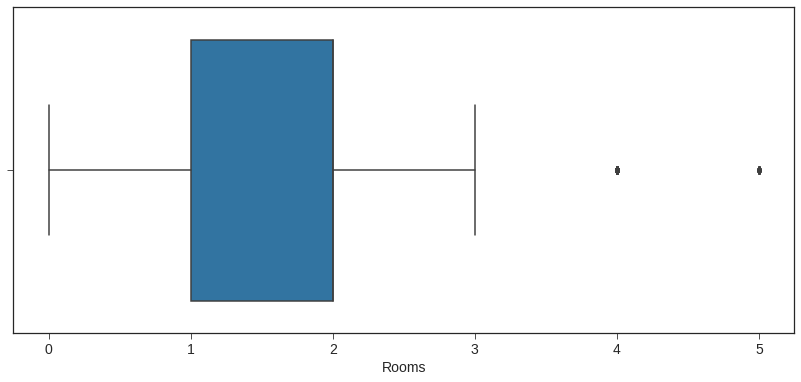

In [137]:
plt.figure(figsize=(14, 6))
sns.boxplot(df_train['Rooms'])

## Анализ площади квартир

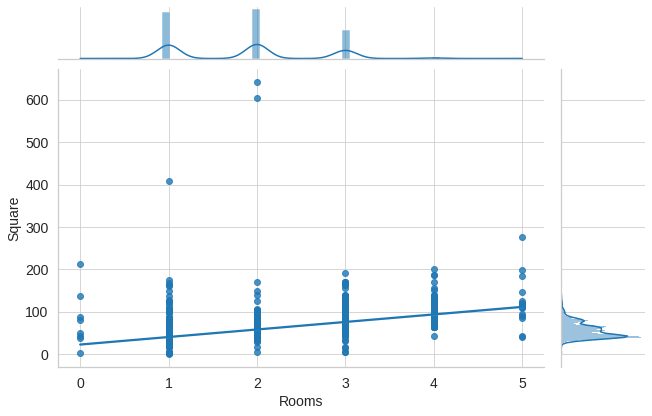

In [138]:
with sns.axes_style(style='whitegrid'):
  grid = sns.jointplot(df_train['Rooms'], df_train['Square'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

В первую очередь обработаем значения с площадью больше 200

In [139]:
df_train.loc[df_train['Square'] > 200]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


Удалим эти 5 значений

In [140]:
df_train.drop(df_train[df_train['Square'] > 200].index, inplace=True)

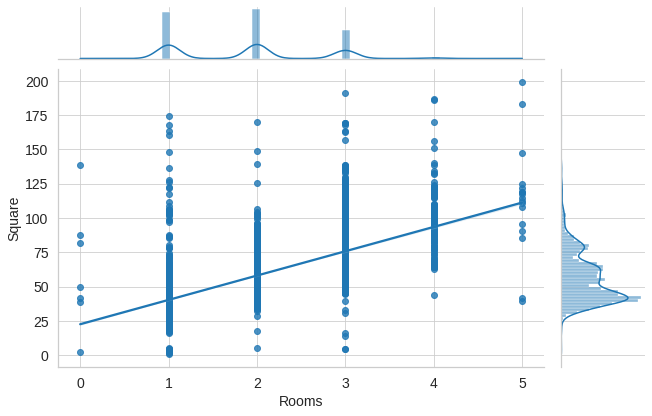

In [141]:
with sns.axes_style(style='whitegrid'):
  grid = sns.jointplot(df_train['Rooms'], df_train['Square'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

### Исправление наверных площадей квартир

Проверим случаи, когда жилая площадь меньше общай площади. Так как этого быть не может, то можно предположить, что в данном случае жилая и общая площади перепутаны местам.

In [142]:
df_foo = df_train.loc[df_train['Square'] < df_train['LifeSquare']]
df_foo.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284


Данных достаточно много, поэтому удалять их не стоит. Необходимо поменять их местами.

In [143]:
df_foo_indexes = df_foo.index

In [144]:
#Данный код последовательно в датасете меняет местами общую плоащдь и площадь жилую
for i in df_foo_indexes:
  new_square = df_foo.loc[i, 'LifeSquare']
  new_lifesquare = df_foo.loc[i, 'Square']
  df_foo.loc[i,'LifeSquare'] = new_lifesquare
  df_foo.loc[i, 'Square'] = new_square
  #print(i, df_foo.loc[i, 'LifeSquare'])

In [145]:
df_foo.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.0,43.967759,42.530043,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
10521,38,3.0,106.340403,104.211396,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
2301,1,2.0,65.224603,61.400054,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
8753,25,3.0,89.803753,85.952306,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
9870,62,1.0,53.491301,51.831473,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284


In [146]:
#Удаляем часть таблицы, где общая площадь меньше площади жилой
df_train.drop(df_train[df_train['Square'] < df_train['LifeSquare']].index, inplace=True)

In [147]:
#Добавляем в таблицу наши исправленные данные
df_train.append(df_foo).head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [148]:
#Проверка
df_train.loc[df_train['Square'] < df_train['LifeSquare']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


Таким образом, удалось поменять местами общую площадь и жилую площадь.

### Поиск зависимостей площадей и комнат

Для начала создадим категориальный признак количества комнат на основе существующего количественного.

In [149]:
bins_rooms = [-0.01, 0, 1.01, 2.01, 3.01, 4.01, 5.01]
label_rooms = ['0', '1', '2', '3', '4', '5']

df_train['Rooms_cat'] = pd.cut(df_train['Rooms'], bins = bins_rooms, labels = label_rooms)

df_train['Rooms_cat'].value_counts()

2    3716
1    3487
3    2140
4     143
5      17
0       7
Name: Rooms_cat, dtype: int64

In [150]:
group_sq_value = df_train.groupby('Rooms_cat')['Square'].median()
group_sq_value

Rooms_cat
0     49.483501
1     40.372621
2     55.593963
3     77.231852
4     98.119575
5    114.313752
Name: Square, dtype: float64

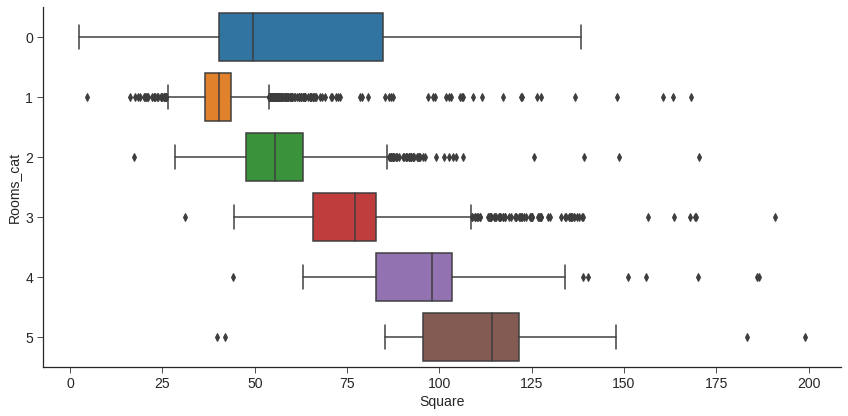

In [151]:
sns.catplot(x='Square', y='Rooms_cat', data= df_train, kind= 'box', size= 6, aspect = 2/1)

При значении комнат 0 похоже на то, что количество комнат просто забыли вписать. При этом графи для нулевого количество комнат подходит для количества комнат от 1 до 3. Так, как в тестовой выборке также присутствуют значения Rooms равные 0, то удалять данную категорию не будем.

In [152]:
df_train = df_train.merge(group_sq_value, on = 'Rooms_cat', how = 'left', suffixes=['', '_gr_sq'])
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_cat,Square_gr_sq
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,2,55.593963
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,3,77.231852
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,2,55.593963
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,2,55.593963
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,1,40.372621


In [153]:
df_train.drop('Rooms_cat', axis = 1, inplace=True)

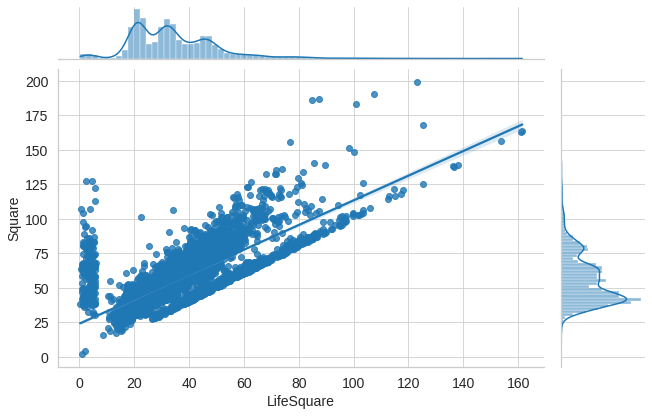

In [154]:
with sns.axes_style(style='whitegrid'):
  grid = sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

Исходя из графика выше можно сделать вывод, что жилая площадь квартии прямопропорциональная общей площади. Однако, имеется большой всплеск в начале графика. Несмотря на это, попробуем с помощью модели линейной регресси заполнить прпоущенные значения.

Очевидно, что заполнить жилую площадь квартиры медианой или какой-либо другой константой некорректно ввиду того, что в выборке с пропусками прусутствуют квартиры разной площадью с разным числом квартир, поэтому, для заполнения данного столбца воспользуемся моделью линейной регрессии, т.к. очевидно, что жилая площадь линейно зависит от общей площади квартиры.

## Обработка пропусков LifeSquare

Для обучения модели из тренировочного датасета выделим отдельный датасет с полностью заполенными строками в столбце LifeSquare. Для обучения понадобятся только столбцы Rooms и Square, т.к. остальные параметры не влияют на жилую площадь.

In [155]:
df_train_for_LSq = df_train[df_train['LifeSquare'].notnull()]
df_train_for_LSq = df_train_for_LSq[['Rooms', 'Square', 'LifeSquare']]

In [156]:
df_train_for_LSq.describe()

,Rooms,Square,LifeSquare
count,7398.000000,7398.000000,7398.000000
mean,1.924709,54.876099,34.440363
std,0.822249,18.214461,15.812069
min,0.000000,2.377248,0.370619
25%,1.000000,41.199845,22.543371
50%,2.000000,50.420070,32.015673
75%,3.000000,64.430698,43.777482
max,5.000000,198.930182,161.504222


In [157]:
#Создание тренировочной и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(df_train_for_LSq[['Rooms', 'Square']], df_train_for_LSq['LifeSquare'], test_size = 0.2, random_state = 42)

In [158]:
#Создание и обучение модели
lr = LinearRegression()

In [159]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [160]:
y_pred = lr.predict(X_test)

In [161]:
r2_score(y_test, y_pred)

0.6023286316508616

Показатель невысокий, но приемлем в нашем случае, т.к. ошибка при этом будет меньше, по сравнению с заполнением покзаателя константой.

In [162]:
#Создаем выборку из незаполненных значений
L_Sq_nan = df_train.loc[df_train['LifeSquare'].isna(), ['Rooms', 'Square']]
L_Sq_nan.shape

(2112, 2)

In [163]:
#С помощью обученной модели заполеним пропуски
L_Sq_pred = lr.predict(L_Sq_nan)

In [164]:
#Заполняем полученные значения в основном датасете
df_train.loc[df_train['LifeSquare'].isna(), ['LifeSquare']] = L_Sq_pred

In [165]:
#Проверим есть ли пропуски
df_train['LifeSquare'].isna().sum()

0

In [166]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9510 entries, 0 to 9509
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     9510 non-null   int64  
 1   Rooms          9510 non-null   float64
 2   Square         9510 non-null   float64
 3   LifeSquare     9510 non-null   float64
 4   KitchenSquare  9510 non-null   float64
 5   Floor          9510 non-null   int64  
 6   HouseFloor     9510 non-null   float64
 7   HouseYear      9510 non-null   int64  
 8   Ecology_1      9510 non-null   float64
 9   Ecology_2      9510 non-null   object 
 10  Ecology_3      9510 non-null   object 
 11  Social_1       9510 non-null   int64  
 12  Social_2       9510 non-null   int64  
 13  Social_3       9510 non-null   int64  
 14  Healthcare_1   5028 non-null   float64
 15  Helthcare_2    9510 non-null   int64  
 16  Shops_1        9510 non-null   int64  
 17  Shops_2        9510 non-null   object 
 18  Price   

##Обработка пропусков Healthcare_1

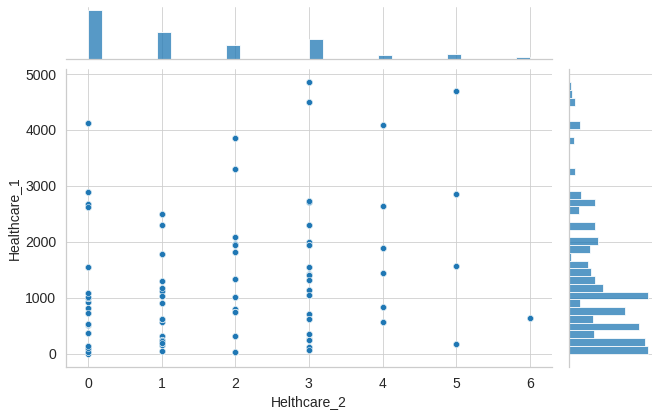

In [167]:
with sns.axes_style(style='whitegrid'):
  grid = sns.jointplot(df_train['Helthcare_2'], df_train['Healthcare_1'])
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

Создадим категориальный признак из Helthcare_2

In [168]:
bins_hc2 = [-0.01, 0, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01]
label_hc2 = ['0', '1', '2', '3', '4', '5', '6']

df_train['Healthcare2_cat'] = pd.cut(df_train['Helthcare_2'], bins = bins_hc2, labels = label_hc2)

df_train['Healthcare2_cat'].value_counts()

0    3900
1    2134
3    1601
2    1121
5     381
4     281
6      92
Name: Healthcare2_cat, dtype: int64

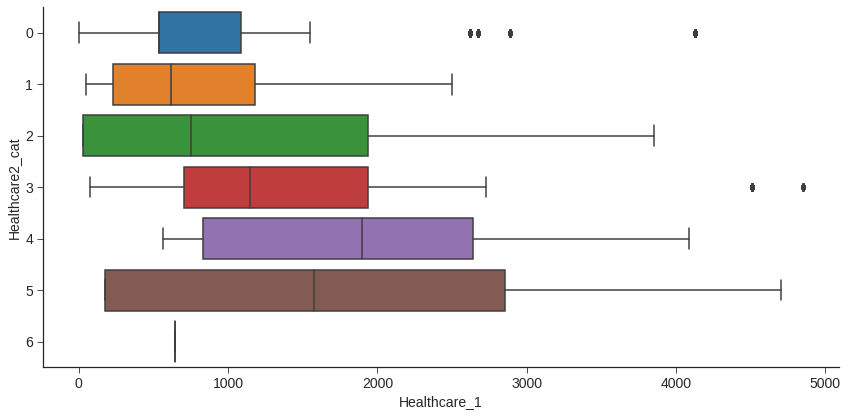

In [169]:
sns.catplot(x='Healthcare_1', y='Healthcare2_cat', data= df_train, kind= 'box', size= 6, aspect = 2/1)

Пропуски в Healthcare_1 заполним по медианому значение Healthcare_2.
  

In [170]:
group_hc_value = df_train.groupby('Healthcare2_cat')['Healthcare_1'].median()
group_hc_value

Healthcare2_cat
0     540.0
1     620.0
2     750.0
3    1145.0
4    1894.0
5    1575.0
6     645.0
Name: Healthcare_1, dtype: float64

In [171]:
df_train['Healthcare1_mean'] = df_train['Healthcare_1']
df_train['Healthcare1_mean'].fillna(group_hc_value, inplace = True)


In [172]:
group_hc_value['0']

540.0

In [173]:
dict(group_hc_value)

{'0': 540.0,
 '1': 620.0,
 '2': 750.0,
 '3': 1145.0,
 '4': 1894.0,
 '5': 1575.0,
 '6': 645.0}

In [174]:
Hc_nan = df_train.loc[df_train[df_train['Healthcare_1'].isna()].index]
Hc_nan.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_gr_sq,Healthcare2_cat,Healthcare1_mean
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,55.593963,0,NaN
6,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377,55.593963,1,NaN
7,74,2.0,80.312926,48.809338,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664,55.593963,0,NaN
8,1,2.0,64.511437,40.022132,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999,55.593963,0,NaN
9,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993,40.372621,0,NaN


In [175]:
for i in Hc_nan.index:
  Hc_nan.loc[i, 'Helthcare_2']
  for key, value in group_hc_value.items():
    if str(Hc_nan.loc[i, 'Helthcare_2']) == key:
      Hc_nan.loc[i, 'Healthcare_1'] = value
      

In [176]:
Hc_nan.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_gr_sq,Healthcare2_cat,Healthcare1_mean
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,540.0,0,11,B,184966.930730,55.593963,0,NaN
6,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,620.0,1,5,B,296021.204377,55.593963,1,NaN
7,74,2.0,80.312926,48.809338,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,540.0,0,2,B,221244.156664,55.593963,0,NaN
8,1,2.0,64.511437,40.022132,1.0,9,17.0,1977,0.007122,B,B,1,264,0,540.0,0,1,B,229102.795999,55.593963,0,NaN
9,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,540.0,0,2,B,95380.220993,40.372621,0,NaN


In [177]:
#Удаляем часть таблицы, где healthcare_1 is null
df_train.drop(df_train[df_train['Healthcare_1'].isna()].index, inplace=True)

In [178]:
df_train.shape

(5028, 22)

In [179]:
#Добавляем в таблицу наши исправленные данные
df_train = df_train.append(Hc_nan)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9510 entries, 1 to 9507
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   DistrictId        9510 non-null   int64   
 1   Rooms             9510 non-null   float64 
 2   Square            9510 non-null   float64 
 3   LifeSquare        9510 non-null   float64 
 4   KitchenSquare     9510 non-null   float64 
 5   Floor             9510 non-null   int64   
 6   HouseFloor        9510 non-null   float64 
 7   HouseYear         9510 non-null   int64   
 8   Ecology_1         9510 non-null   float64 
 9   Ecology_2         9510 non-null   object  
 10  Ecology_3         9510 non-null   object  
 11  Social_1          9510 non-null   int64   
 12  Social_2          9510 non-null   int64   
 13  Social_3          9510 non-null   int64   
 14  Healthcare_1      9510 non-null   float64 
 15  Helthcare_2       9510 non-null   int64   
 16  Shops_1           9510 n

In [180]:
#Удаляем вспомогательный столбец Healthcare1_mean
df_train.drop('Healthcare1_mean', axis = 1, inplace=True)

In [181]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9510 entries, 1 to 9507
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DistrictId       9510 non-null   int64   
 1   Rooms            9510 non-null   float64 
 2   Square           9510 non-null   float64 
 3   LifeSquare       9510 non-null   float64 
 4   KitchenSquare    9510 non-null   float64 
 5   Floor            9510 non-null   int64   
 6   HouseFloor       9510 non-null   float64 
 7   HouseYear        9510 non-null   int64   
 8   Ecology_1        9510 non-null   float64 
 9   Ecology_2        9510 non-null   object  
 10  Ecology_3        9510 non-null   object  
 11  Social_1         9510 non-null   int64   
 12  Social_2         9510 non-null   int64   
 13  Social_3         9510 non-null   int64   
 14  Healthcare_1     9510 non-null   float64 
 15  Helthcare_2      9510 non-null   int64   
 16  Shops_1          9510 non-null   int64   


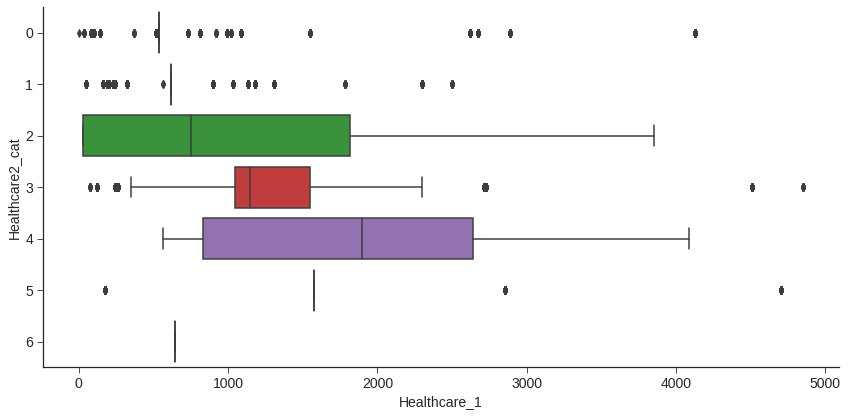

In [182]:
sns.catplot(x='Healthcare_1', y='Healthcare2_cat', data= df_train, kind= 'box', size= 6, aspect = 2/1)

Поведение признака ухудшилось попробуем выполнить трансформацию признака. Для этого из значения признака извлечем корень четвертой степени.

In [183]:
df_train['Healthcare_1_log'] = (df_train['Healthcare_1'])**(1/4)

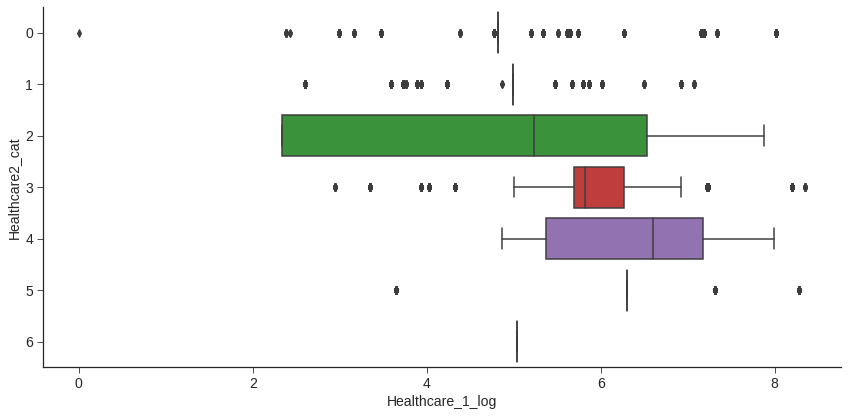

In [184]:
sns.catplot(x='Healthcare_1_log', y='Healthcare2_cat', data= df_train, kind= 'box', size= 6, aspect = 2/1)

In [389]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Square_gr_sq
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9.510000e+03,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,51.296635,1.892324,56.035102,34.986476,6.398212,8.456572,12.551420,4.092723e+03,0.119646,25.182019,5449.377392,7.967508,914.016930,1.341746,4.265195,214838.599671,55.621817
std,44.050397,0.812002,18.642424,15.228967,29.213109,5.173746,6.567785,2.056008e+05,0.119368,17.430872,3991.307423,23.392446,806.875284,1.494524,4.765675,92496.326078,14.957155
min,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,40.372621
25%,21.000000,1.000000,41.811354,23.426309,1.000000,4.000000,9.000000,1.973000e+03,0.019509,8.000000,1892.000000,0.000000,540.000000,0.000000,1.000000,155147.927408,40.372621
50%,37.000000,2.000000,52.432000,32.657097,6.000000,7.000000,12.000000,1.977000e+03,0.075779,25.000000,5288.000000,2.000000,620.000000,1.000000,3.000000,192947.952475,55.593963
75%,78.000000,2.000000,65.831162,43.679753,9.000000,12.000000,17.000000,1.999000e+03,0.195781,36.000000,7425.000000,5.000000,1130.000000,2.000000,6.000000,250029.755137,55.593963
max,209.000000,5.000000,198.930182,161.504222,2014.000000,42.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,114.313752
